In [ ]:
#ljn

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from keras.datasets import mnist
import os 
from keras.models import Model
from keras.layers import Input , Conv2D , Reshape , Dense , MaxPooling2D , Conv2DTranspose , UpSampling2D , Flatten , Dense , BatchNormalization , Multiply , Add
from keras.preprocessing import image
from keras.layers.advanced_activations import LeakyReLU
from keras import backend as b
import tensorflow as tf

In [ ]:
(x_train , _) , (x_test , _) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
x_train.dtype , x_test.dtype , x_train.shape , x_test.shape

(dtype('uint8'), dtype('uint8'), (60000, 28, 28), (10000, 28, 28))

In [ ]:
x_train = x_train / 255
x_test = x_test / 255

In [ ]:
x_train = x_train.reshape(-1 , x_train.shape[1] , x_train.shape[2] , 1)
x_test = x_test.reshape(-1 , x_train.shape[1] , x_train.shape[2] , 1)

Text(0.5, 0.98, 'test data')

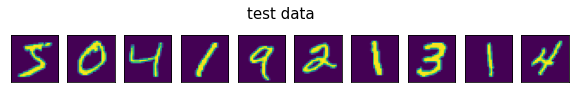

In [ ]:
plt.figure(figsize = (10 , 1.5))
for i in range(10):
  ax = plt.subplot(1 , 10 , i+1)
  ax.imshow(x_train[i][:,:,0])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.suptitle('test data' , fontsize = 15)

In [ ]:
import math
def split_df_chunks(data_df,chunk_size):
    total_length     = len(data_df)
    total_chunk_num  = math.ceil(total_length/chunk_size)
    normal_chunk_num = math.floor(total_length/chunk_size)
    chunks = []
    for i in range(normal_chunk_num):
        chunk = data_df[(i*chunk_size):((i+1)*chunk_size)]
        chunks.append(chunk)
    if total_chunk_num > normal_chunk_num:
        chunk = data_df[(normal_chunk_num*chunk_size):total_length]
        chunks.append(chunk)
    return chunks

In [ ]:
x = split_df_chunks(x_train,30)

# Building the model :

In [ ]:
l = 10
i = Input(shape = (28 , 28 , 1))
x = Conv2D(16 , (3 , 3) , activation = 'relu' , padding = 'same')(i)
x = MaxPooling2D((2 , 2))(x)
x = Conv2D(64 , (3 , 3) , activation = 'relu' , padding = 'same')(x)
x = MaxPooling2D((2 , 2))(x)
x = Conv2D(128 , (3 , 3) , activation = 'relu' , padding = 'same')(x)
x = Flatten()(x)
x = Dense(1024 , activation = LeakyReLU(0.2))(x)
encoder_o = BatchNormalization()(x)

mu = Dense(l)(encoder_o)
log_var = Dense(l)(encoder_o)

epsilon = b.random_normal(shape = (tf.shape(mu)[0] , tf.shape(mu)[1]))
sigma = tf.exp(0.5 * log_var)

z_e = Multiply()([sigma , epsilon])
z = Add()([mu , z_e])

encoder = Model(i , outputs = [mu , log_var , z] , name = 'encoded')
encoder.summary()

Model: "encoded"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 16)   160         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 14, 14, 16)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 64)   9280        ['max_pooling2d[0][0]']          
                                                                                            

In [ ]:
io = Input(shape = (l ,))
x = Dense(1024 , activation = 'relu')(io)
x = BatchNormalization()(x)

x = Dense(6272 , activation = 'relu')(io)
x = Reshape((7,7,128))(x)

x = Conv2DTranspose(128 , (3 , 3) , activation = 'relu' , strides = 2 , padding = 'same')(x)
x = BatchNormalization()(x)

x = Conv2DTranspose(64 , (3 , 3) , activation = 'relu' , padding = 'same')(x)
x = UpSampling2D((2 , 2))(x)
x = BatchNormalization()(x)

x = Conv2DTranspose(16 , (3 , 3) , activation = 'relu' , padding = 'same')(x)
x = BatchNormalization()(x)

x = Conv2DTranspose(1 , (3 , 3) , activation = 'relu' , padding = 'same')(x)
o = BatchNormalization()(x)

decoder = Model(io , o , name = 'decoded')
decoder.summary()

Model: "decoded"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_4 (Dense)             (None, 6272)              68992     
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      147584    
 nspose)                                                         
                                                                 
 batch_normalization_2 (Batc  (None, 14, 14, 128)      512       
 hNormalization)                                                 
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 14, 14, 64)       7379

In [ ]:
def reconstruction_loss(y, y_pred):
    return tf.reduce_mean(tf.square(y - y_pred))

def kl_loss(mu, log_var):
    loss = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mu) - tf.exp(log_var))
    return loss

def total_loss(y_true, y_pred, mu, log_var):
    return reconstruction_loss(y_true, y_pred) + (1 / (64*64)) * kl_loss(mu, log_var)

In [ ]:
mu, log_var, z = encoder(i)
decoded = decoder(z)
model = Model(i, decoded, name ="vae")
loss = kl_loss(mu, log_var)
model.add_loss(loss)
model.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 encoded (Functional)           [(None, 10),         6531444     ['input_1[0][0]']                
                                 (None, 10),                                                      
                                 (None, 10)]                                                      
                                                                                                  
 decoded (Functional)           (None, 28, 28, 1)    300581      ['encoded[0][2]']                
                                                                                                

In [ ]:
reconstructed = model(x)

In [ ]:
x = split_df_chunks(x_train,30)

In [ ]:
from tensorflow.keras.optimizers import Adam

random_vector = tf.random.normal(shape = (25, l,))


mse_losses = []
kl_losses = []

optimizer = Adam(0.001, 0.5)
epochs = 10

for epoch in range(1, epochs + 1):
    print("Epoch: ", epoch)
    for step, training_batch in enumerate(x):
        with tf.GradientTape() as tape:
            reconstructed = model(training_batch)
            y_true = tf.reshape(training_batch, shape = [-1])
            y_true = tf.cast(y_true, tf.float32)
            y_pred = tf.reshape(reconstructed, shape = [-1])
            
            mse_loss = reconstruction_loss(y_true, y_pred)
            mse_losses.append(mse_loss.numpy())
            
            kl = sum(model.losses)
            kl_losses.append(kl.numpy())
            
            train_loss = 0.01 * kl + mse_loss
            
            grads = tape.gradient(train_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            
            print("Epoch: %s - Step: %s - MSE loss: %s - KL loss: %s" % (epoch, step, mse_loss.numpy(), kl.numpy()))

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Epoch: 8 - Step: 1002 - MSE loss: 0.017647266 - KL loss: 1.4816558
Epoch: 8 - Step: 1003 - MSE loss: 0.018091526 - KL loss: 1.4103936
Epoch: 8 - Step: 1004 - MSE loss: 0.017131211 - KL loss: 1.3736252
Epoch: 8 - Step: 1005 - MSE loss: 0.01582995 - KL loss: 1.430374
Epoch: 8 - Step: 1006 - MSE loss: 0.016189758 - KL loss: 1.3832374
Epoch: 8 - Step: 1007 - MSE loss: 0.017909149 - KL loss: 1.3807263
Epoch: 8 - Step: 1008 - MSE loss: 0.018446133 - KL loss: 1.3873044
Epoch: 8 - Step: 1009 - MSE loss: 0.01347716 - KL loss: 1.3916949
Epoch: 8 - Step: 1010 - MSE loss: 0.016302487 - KL loss: 1.3745525
Epoch: 8 - Step: 1011 - MSE loss: 0.015713997 - KL loss: 1.410586
Epoch: 8 - Step: 1012 - MSE loss: 0.015423249 - KL loss: 1.2646381
Epoch: 8 - Step: 1013 - MSE loss: 0.018236564 - KL loss: 1.4321245
Epoch: 8 - Step: 1014 - MSE loss: 0.01670282 - KL loss: 1.378971
Epoch: 8 - Step: 1015 - MSE loss: 0.020103507 - KL loss: 

In [ ]:
reconstructed = model(training_batch)

Text(0.5, 0.98, 'train data')

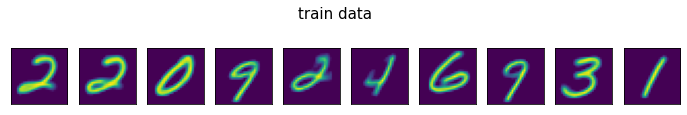

In [ ]:
plt.figure(figsize = (12,2))
for i in range(10):
  ax = plt.subplot(1,10,i+1)
  ax.imshow(image.array_to_img(reconstructed[i]))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.suptitle('train data' , fontsize = 15)